## 2. Transhipment Problem

### Problem Statement

**SandyCo Part II - Problem Background:**
- SandyCo still has 2 facilities that mine, clean, and sort sand for use in cement, children’s playboxes, and small beaches. They have added two packaging centres to the network. The sand now moves from the plants to the packaging centres and then to the regions.
- Each plant has a specific maximum weekly supply of available sand and each region has an expected minimum weekly required demand. The cost to distribute a ton of sand differs between each plant, packaging centre, and region combination due to distance and other factors.

**Problem Objective:**
- How much sand should SandyCo ship from each plant to each packaging centre and then to each region each week to meet demand at the lowest planned distribution costs?

### Model Formulation
To formulate the transhipment problem as a linear programming model, we define the following:

**Indices:**
- $i$ = Origin index (plant, packaging centre)
- $j$ = Destination index (packaging centre, region)

**Decision Variables:**
- $x_{ij}$ = Amount of goods transported from origin $i$ to destination $j$

**Parameters:**
- $S_i$ = Supply capacity of plant $i$
- $D_j$ = Demand requirement of region $j$
- $c_{ij}$ = Cost of transporting one unit of goods from origin $i$ to destination $j$

**Objective Function:**
$$\min z: \sum_{i} \sum_{j} c_{ij} x_{ij}$$

**Constraints:**
1. Supply constraints:
$\sum_{j} x_{ij} \leq S_i \quad \forall i \in \text{plants}$
2. Demand constraints:
$\sum_{i} x_{ij} \geq D_j \quad \forall j \in \text{regions}$
3. Transhipment (flow conservation) constraints:
$\sum_{i} x_{ij} = \sum_{k} x_{jk} \quad \forall j \in \text{packaging centres}$
4. Non-negativity constraints:
$x_{ij} \geq 0 \quad \forall i, j$

### Python Implementation

We are going to define some functions to solve the transshipment problem, a type of network flow optimisation problem. The functions are designed to be highly automated, requiring minimal manual input once the initial parameters are set. Below is a detailed description of each function and its purpose.

#### `solve_transshipment_problem`

This function formulates and solves the transshipment problem given the nodes, supply, demand, and cost data. It uses the `pulp` library for linear programming and provides options to plot the network and generate a stacked bar chart for visualising the flow.

**Parameters:**
- `nodes` (dict): Dictionary containing lists of source nodes, transshipment nodes, and destination nodes.
- `supply` (dict): Supply values for each source node.
- `demand` (dict): Demand values for each destination node.
- `cost` (dict): Cost of transportation between nodes.
- `plot_network` (bool): Whether to plot the transshipment network. Default is `False`.
- `plot_bar_chart` (bool): Whether to plot the stacked bar chart. Default is `False`.

**Returns:**
- `results_df` (pd.DataFrame): DataFrame containing the flow values.
- `total_cost` (float): Total cost of the solution.

**Importance:**
- The function is highly automated, solving the problem and generating visualisations with minimal manual intervention once the input values are provided.

#### `plot_transshipment_network`

This function plots the transshipment network, displaying the nodes, edges, and the flow values between them.

**Parameters:**
- `nodes` (dict): Dictionary containing lists of source nodes, transshipment nodes, and destination nodes.
- `supply` (dict): Supply values for each source node.
- `demand` (dict): Demand values for each destination node.
- `cost` (dict): Cost of transportation between nodes.
- `flow` (dict): Flow values between nodes as decision variables from the optimisation result.

**Importance:**
- Provides a visual representation of the network, helping to understand the flow dynamics and the relationships between different nodes.

#### `plot_stacked_bar_chart`

This function generates stacked bar charts to visualise the flow of goods from sources to transshipment nodes and from transshipment nodes to destination nodes.

**Parameters:**
- `flow` (dict): Flow values between nodes as decision variables from the optimisation result.
- `nodes` (dict): Dictionary containing lists of source nodes, transshipment nodes, and destination nodes.

**Importance:**
- The stacked bar charts offer an intuitive way to compare the flow distributions and understand the allocation of resources across the network.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pulp

def solve_transshipment_problem(nodes, supply, demand, cost, plot_network=False, plot_bar_chart=False):
    sources = nodes['sources']
    transshipments = nodes['transshipments']
    destinations = nodes['destinations']

    # Define the problem
    problem = pulp.LpProblem("Transshipment_Problem", pulp.LpMinimize)

    # Decision variables
    flow = {(i, j): pulp.LpVariable(f"flow_{i}_{j}", lowBound=0, cat='Continuous') for (i, j) in cost}

    # Objective function
    problem += pulp.lpSum(cost[i, j] * flow[i, j] for (i, j) in cost), "Total Cost"

    # Supply constraints
    for i in sources:
        problem += pulp.lpSum(flow[i, j] for j in transshipments) <= supply[i], f"Supply_{i}"

    # Demand constraints
    for j in destinations:
        problem += pulp.lpSum(flow[i, j] for i in transshipments) >= demand[j], f"Demand_{j}"

    # Transshipment constraints
    for k in transshipments:
        problem += pulp.lpSum(flow[i, k] for i in sources) == pulp.lpSum(flow[k, j] for j in destinations), f"Transshipment_{k}"

    # Solve the problem
    problem.solve()

    # Store results in DataFrame
    results = [(v.name, v.varValue) for v in problem.variables()]
    results_df = pd.DataFrame(results, columns=['Variable', 'Value'])

    # Extract total cost
    total_cost = pulp.value(problem.objective)

    # Optionally plot the network
    if plot_network:
        plot_transshipment_network(nodes, supply, demand, cost, flow)

    # Optionally plot the stacked bar chart
    if plot_bar_chart:
        plot_stacked_bar_chart(flow, nodes)
    
    return results_df, total_cost

def plot_transshipment_network(nodes, supply, demand, cost, flow):
    sources = nodes['sources']
    transshipments = nodes['transshipments']
    destinations = nodes['destinations']

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    for node in sources + transshipments + destinations:
        G.add_node(node)

    # Add edges with weights
    for (i, j) in cost:
        G.add_edge(i, j, weight=cost[i, j], capacity=flow[i, j].varValue)

    # Set custom positions for the nodes
    pos = {
        'P1': (0, 0), 'P2': (0, 2),
        'CA': (1, 0), 'CB': (1, 3),
        'R1': (2, 3), 'R2': (2, 1), 'R3': (2, -1)
    }

    # Draw the network graph
    plt.figure(figsize=(14, 8))  # Adjust the figure size as needed
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Draw edge labels with the flow values
    edge_labels = {(i, j): f"{flow[i, j].varValue:.1f}" for (i, j) in cost}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title('Transshipment Network Flow')
    plt.show()

def plot_stacked_bar_chart(flow, nodes):
    sources = nodes['sources']
    transshipments = nodes['transshipments']
    destinations = nodes['destinations']

    # Create a DataFrame to hold flow values for plotting
    flow_data = {
        'From': [],
        'To': [],
        'Flow': []
    }

    for (i, j), var in flow.items():
        flow_data['From'].append(i)
        flow_data['To'].append(j)
        flow_data['Flow'].append(var.varValue)

    flow_df = pd.DataFrame(flow_data)

    # Create separate DataFrames for each category
    flow_sources_to_transshipments = flow_df[flow_df['From'].isin(sources)]
    flow_transshipments_to_destinations = flow_df[flow_df['From'].isin(transshipments)]

    # Plot the stacked bar chart for sources to transshipments
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bottom = pd.Series([0] * len(transshipments), index=transshipments)
    for source in sources:
        values = flow_sources_to_transshipments[flow_sources_to_transshipments['From'] == source].set_index('To')['Flow']
        ax.bar(transshipments, values, bottom=bottom[transshipments], label=source)
        bottom += values

    ax.set_xlabel('Transshipment Nodes')
    ax.set_ylabel('Flow Values')
    ax.set_title('Flow from Sources to Transshipment Nodes')
    ax.legend(title='From')

    plt.show()

    # Plot the stacked bar chart for transshipments to destinations
    fig, ax = plt.subplots(figsize=(10, 6))

    bottom = pd.Series([0] * len(destinations), index=destinations)
    for transshipment in transshipments:
        values = flow_transshipments_to_destinations[flow_transshipments_to_destinations['From'] == transshipment].set_index('To')['Flow']
        ax.bar(destinations, values, bottom=bottom[destinations], label=transshipment)
        bottom += values

    ax.set_xlabel('Destination Nodes')
    ax.set_ylabel('Flow Values')
    ax.set_title('Flow from Transshipment Nodes to Destinations')
    ax.legend(title='From')

    plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jonathanduquegonzalez/myenv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/lz/hqm78w6x12b2gll67jmrwpn00000gn/T/3494cd2fcc39495ca9dc7a99632841bd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/lz/hqm78w6x12b2gll67jmrwpn00000gn/T/3494cd2fcc39495ca9dc7a99632841bd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 43 RHS
At line 51 BOUNDS
At line 52 ENDATA
Problem MODEL has 7 rows, 10 columns and 20 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 10 (0) columns and 20 (0) elements
0  Obj 0 Primal inf 200 (3)
6  Obj 56700
Optimal - objective value 56700
Optimal objective 56700 - 6 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01



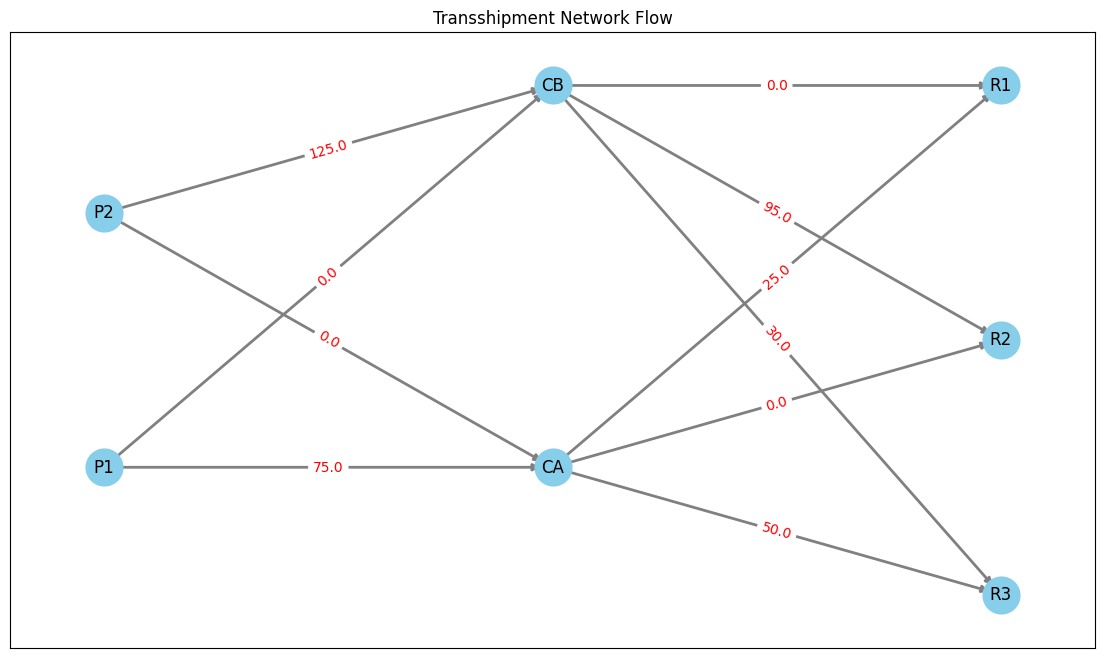

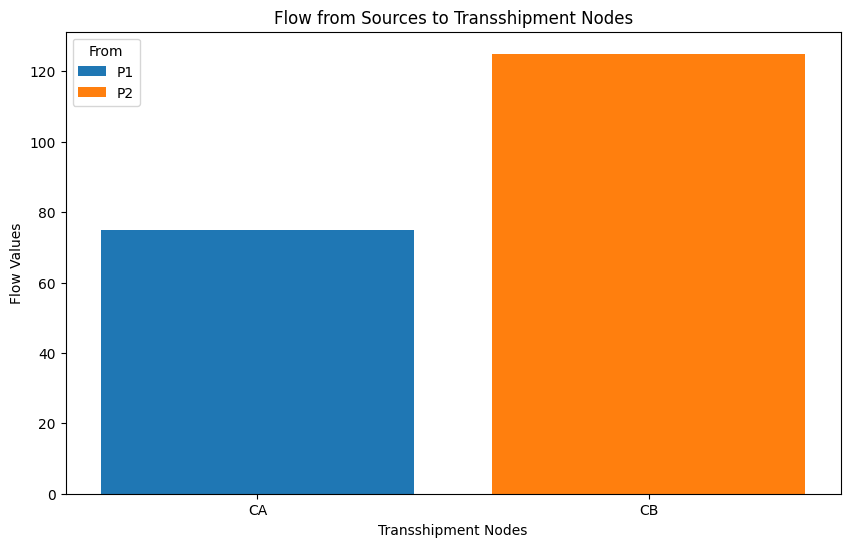

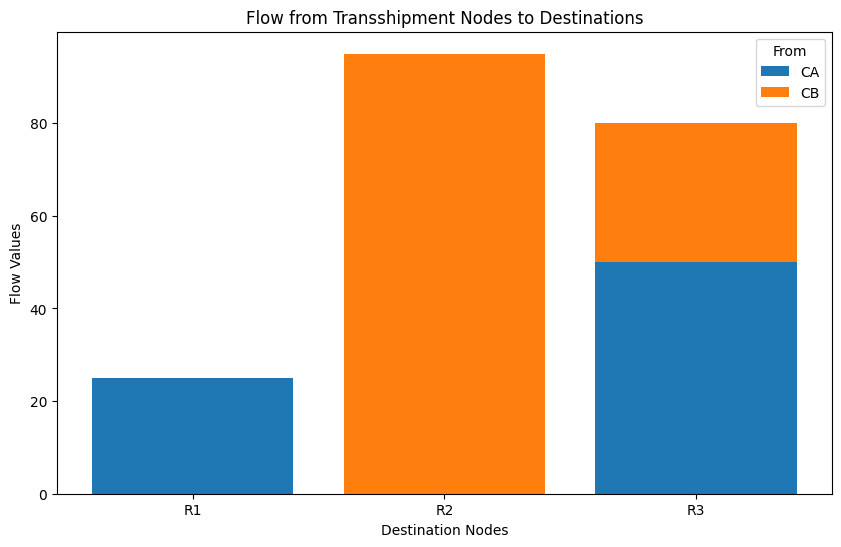


Total Cost:
56700.0


,Variable,Value
0,flow_CA_R1,25.0
1,flow_CA_R2,0.0
2,flow_CA_R3,50.0
3,flow_CB_R1,0.0
4,flow_CB_R2,95.0
5,flow_CB_R3,30.0
6,flow_P1_CA,75.0
7,flow_P1_CB,0.0
8,flow_P2_CA,0.0
9,flow_P2_CB,125.0


In [2]:
nodes = {
    'sources': ['P1', 'P2'],
    'transshipments': ['CA', 'CB'],
    'destinations': ['R1', 'R2', 'R3']
}

supply = {'P1': 100, 'P2': 125}
demand = {'R1': 25, 'R2': 95, 'R3': 80}
cost = {
    ('P1', 'CA'): 190, ('P1', 'CB'): 210,
    ('P2', 'CA'): 185, ('P2', 'CB'): 105,
    ('CA', 'R1'): 175, ('CA', 'R2'): 180, ('CA', 'R3'): 165,
    ('CB', 'R1'): 235, ('CB', 'R2'): 130, ('CB', 'R3'): 145
}

# Solve the problem, store results in DataFrame, and plot the network and bar chart
results_df, total_cost = solve_transshipment_problem(nodes, supply, demand, cost, plot_network=True, plot_bar_chart=True)

print("\nTotal Cost:")
print(total_cost)

results_df